In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append("../utils")
import toolbox_ML as tb
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

In [2]:
df=pd.read_csv('../data_sample/ai4i2020.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [3]:
# Renombrar Columnas para que sea más cómodo trabajar con ellas
df.rename(columns = {'Product ID':'Product_ID',
                    'Air temperature [K]':'Air_temperature',
                     'Process temperature [K]':'Process_temperature',
                     'Rotational speed [rpm]':'Rotational_speed',
                     'Torque [Nm]':'Torque',
                     'Tool wear [min]':'Tool_wear',
                     'Machine failure':'Machine_failure',},
          inplace = True)

In [4]:
df.Tool_wear.value_counts()

Tool_wear
0      120
2       69
5       63
7       58
59      58
      ... 
237      1
239      1
241      1
251      1
253      1
Name: count, Length: 246, dtype: int64

In [5]:
# Codificar 'Type' para valores numéricos
df['Type'] = df['Type'].map({'L': 1, 'M': 2, 'H': 3})


In [6]:
# Incluimos todos los fallos en la columa Machine_failure ya que hay fallos que no están contemplados.
columnas_fallos=["TWF","HDF","PWF","OSF","RNF"]
for i in columnas_fallos:
    df.loc[df[i] == 1, 'Machine_failure'] = 1

In [7]:
#Dado que hay una columan de error de pontencia agregamos una nuevacolumna con el valor de la pontencia.
#Esto facilitará la clasficicacion de este error.
df['Power'] = df[['Rotational_speed', 'Torque']].product(axis=1)

In [8]:
# Eliminamos las columnas que no aportan información relevante para el modelo
df.drop(columns=['Product_ID','UDI'], axis=1, inplace=True)

In [9]:
#Eliminamos las columnas de fallos ya que hemos incluido todos los fallos en la columna Machine_failure
df.drop(columns=columnas_fallos, axis=1, inplace=True)

In [10]:
# Separar features y target
X = df.drop(columns=['Machine_failure'])
y = df['Machine_failure']

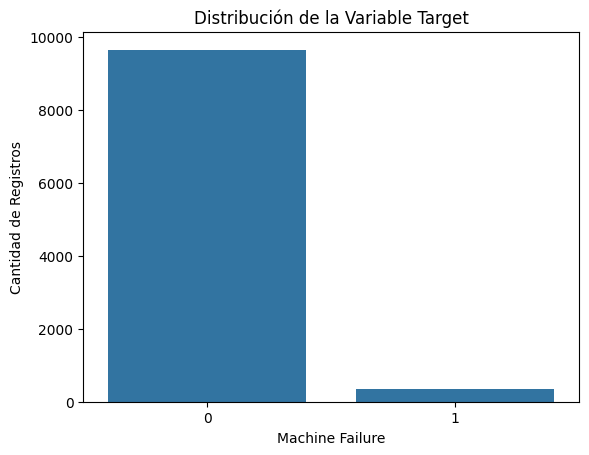

In [11]:
sns.countplot(x=df['Machine_failure'])
plt.title('Distribución de la Variable Target')
plt.xlabel('Machine Failure')
plt.ylabel('Cantidad de Registros')
plt.show()

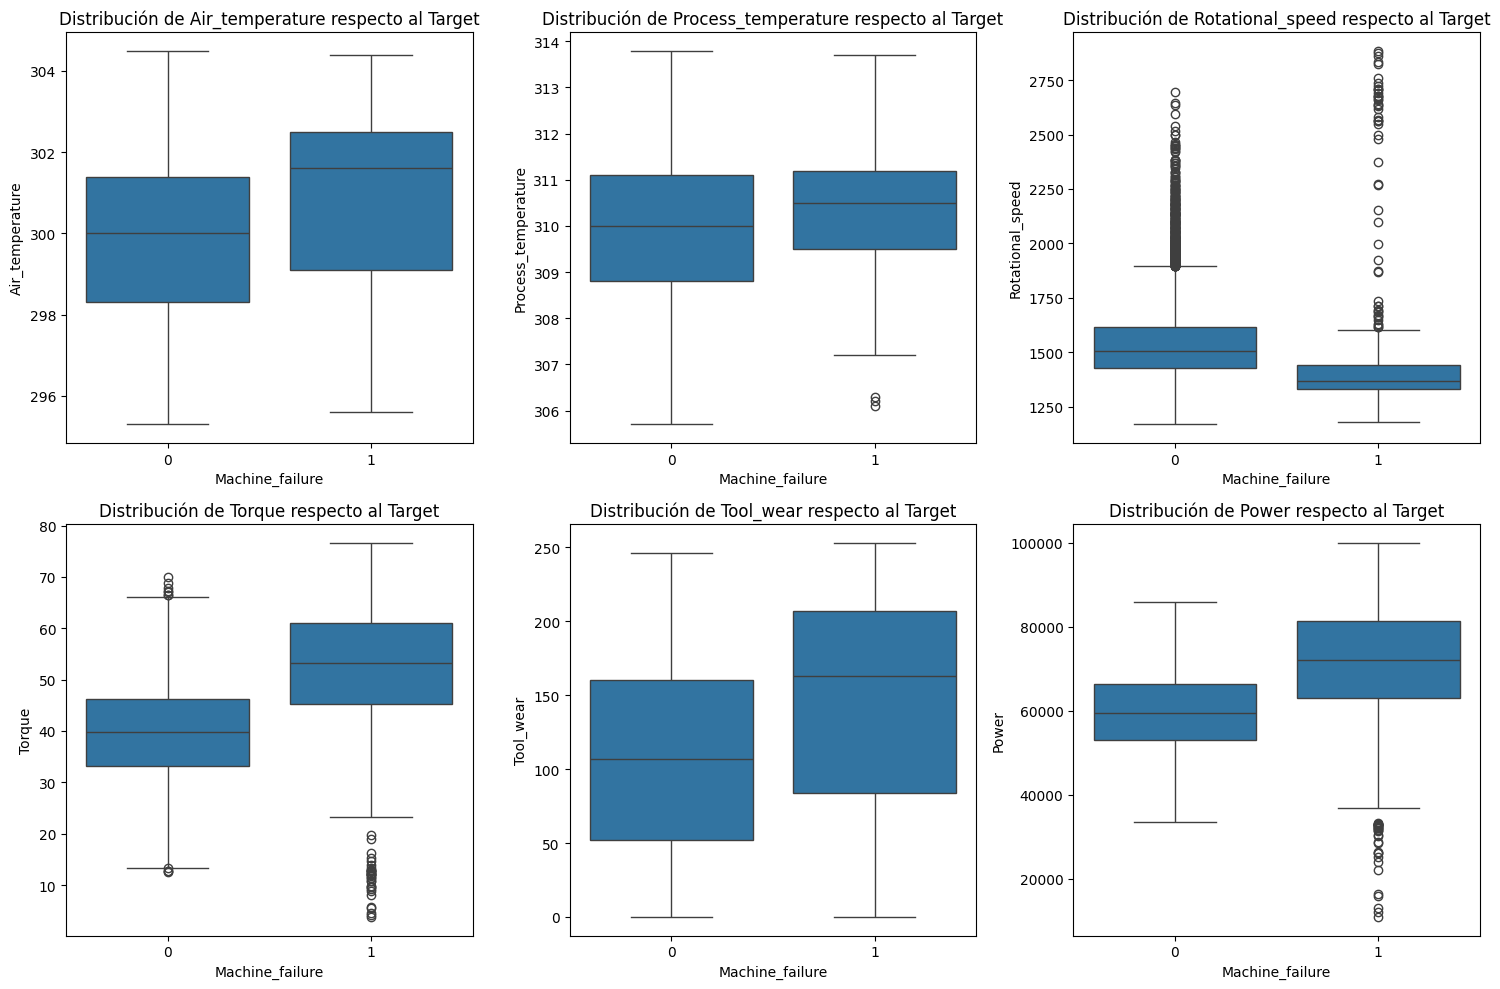

In [12]:
# Análisis de variables numéricas respecto al target
num_cols = ['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear','Power']

# Boxplots
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df['Machine_failure'], y=df[col])
    plt.title(f'Distribución de {col} respecto al Target')
plt.tight_layout()
plt.show()

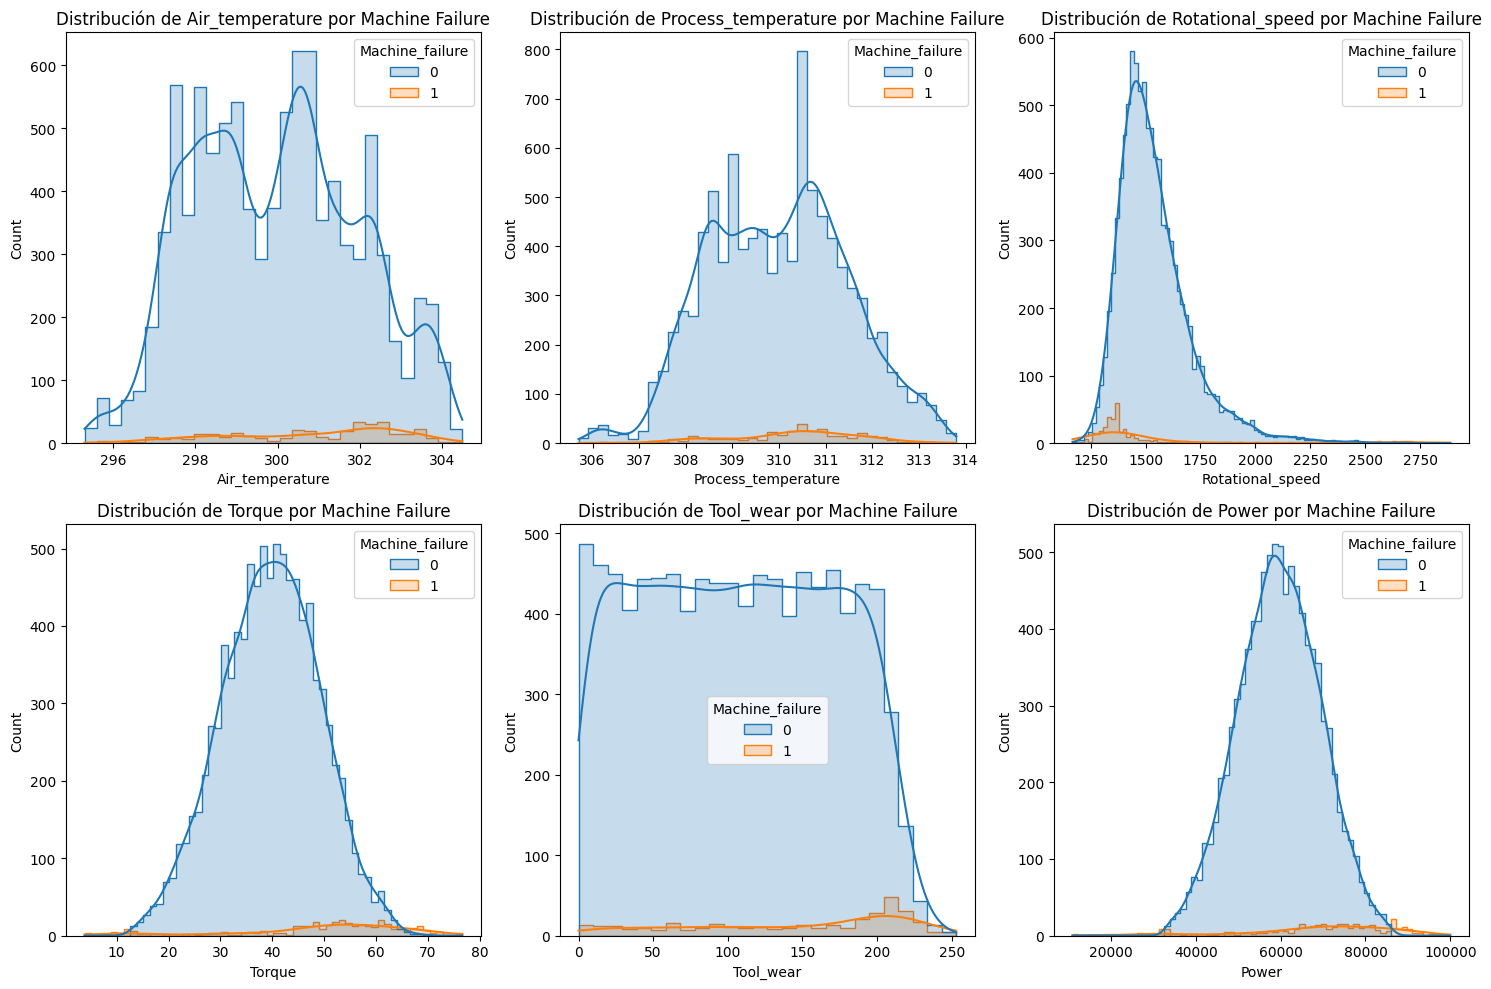

In [18]:
# Histogramas
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=df, x=col, hue='Machine_failure', element='step', kde=True)
    plt.title(f'Distribución de {col} por Machine Failure')
plt.tight_layout()
plt.show()

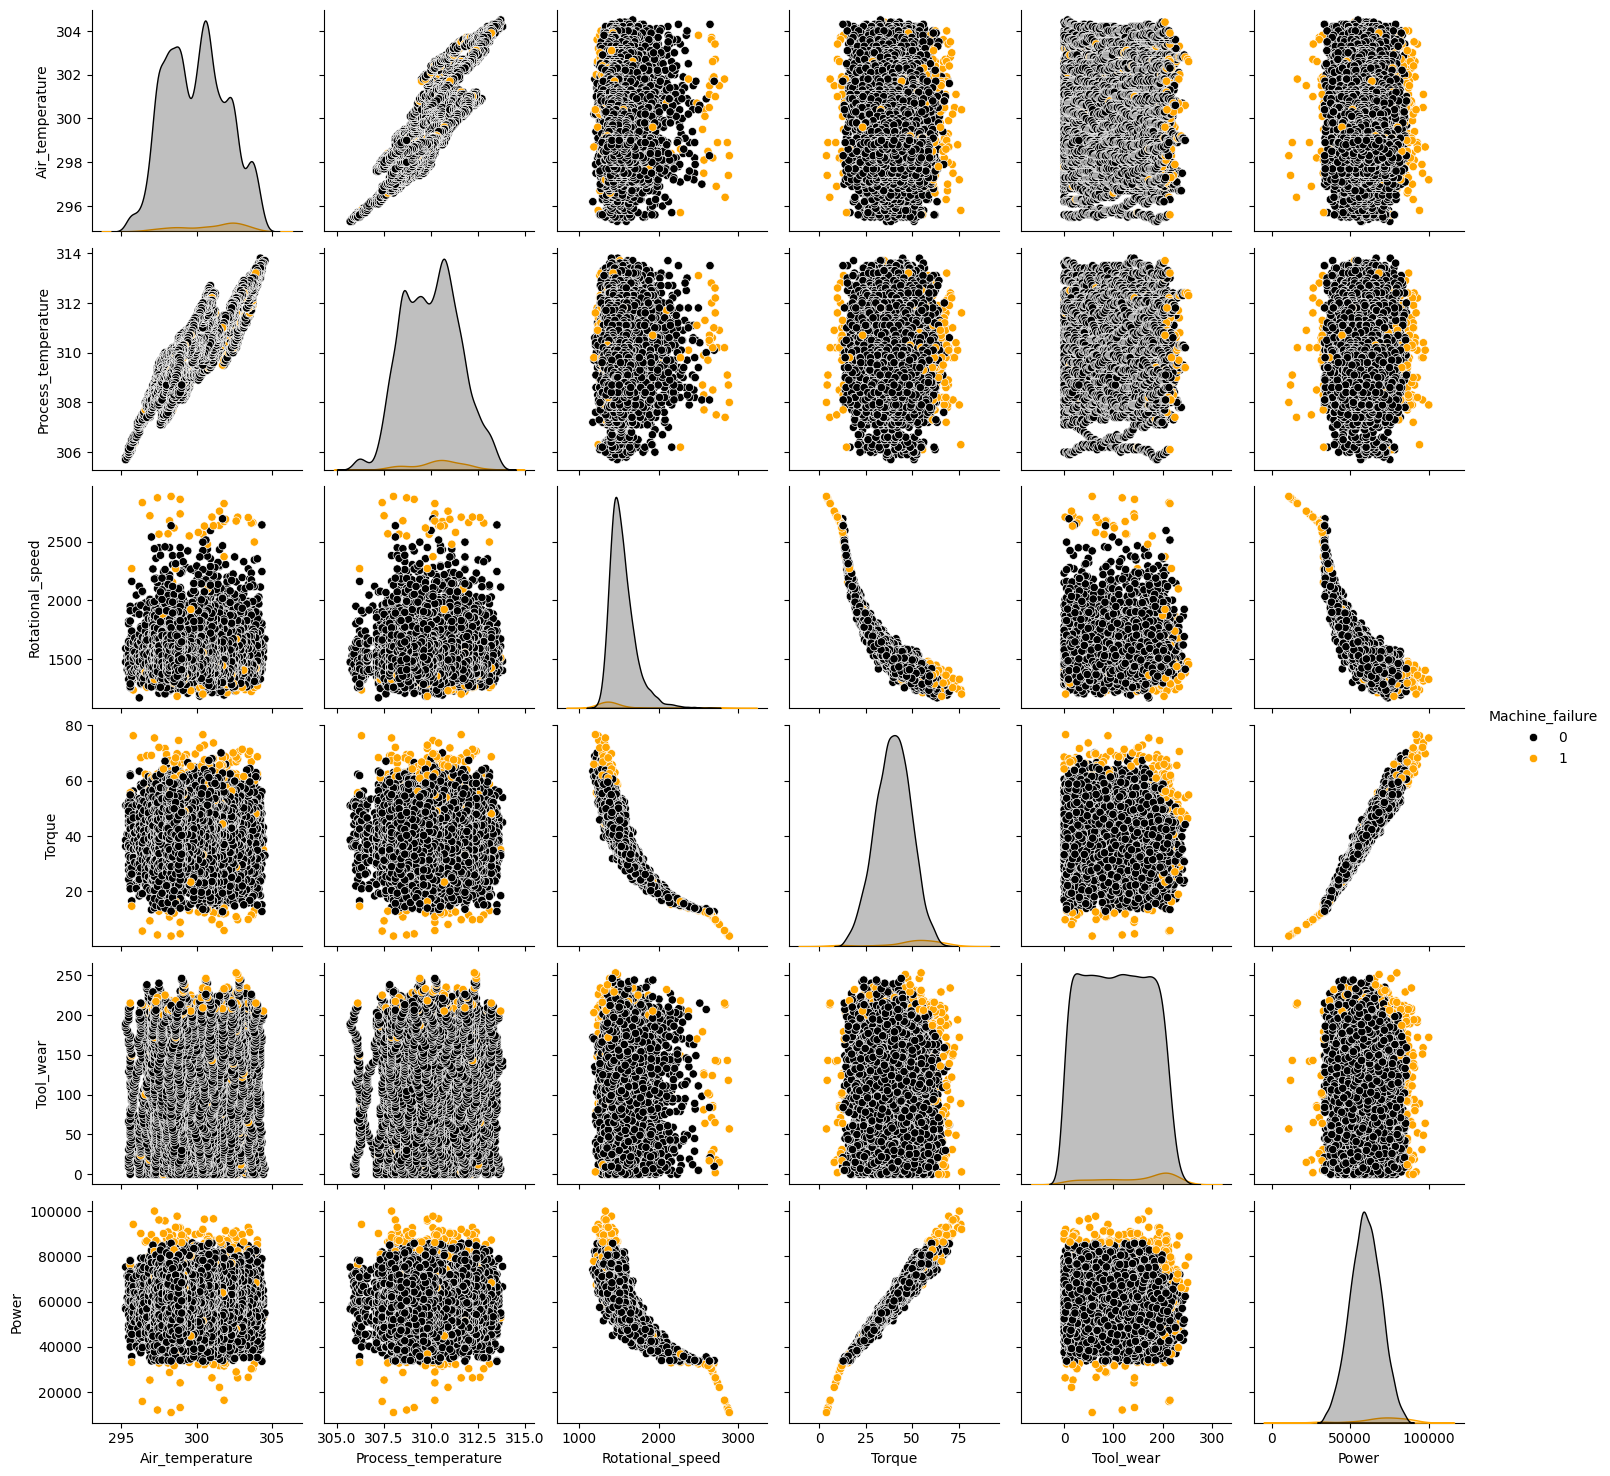

In [13]:
# List of numerical features to be analyzed, based on the dataset description 
num_cols = [
    'Air_temperature', 
    'Process_temperature', 
    'Rotational_speed', 
    'Torque', 
    'Tool_wear',
    'Power'
]

# Generating pairplot
sns.pairplot(df[num_cols + ['Machine_failure']], hue='Machine_failure', palette={0: 'black', 1: 'orange'})
plt.show()

In [14]:
X = df[num_cols]
X.head()

,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Power
0,298.1,308.6,1551,42.8,0,66382.8
1,298.2,308.7,1408,46.3,3,65190.4
2,298.1,308.5,1498,49.4,5,74001.2
3,298.2,308.6,1433,39.5,7,56603.5
4,298.2,308.7,1408,40.0,9,56320.0


In [15]:
# División en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [16]:
"""
from sklearn.feature_selection import SelectKBest, f_classif

'''
f_classif realiza un test ANOVA
a técnica de análisis de varianza (ANOVA) también conocida como análisis factorial y desarrollada por Fisher en 1930,
constituye la herramienta básica para el estudio del efecto de uno o más factores (cada uno con dos o más niveles) sobre
la media de una variable continua. Es por lo tanto el test estadístico a emplear cuando se desea comparar las medias de
dos o más grupos.
'''
selector = SelectKBest(f_classif, k=6)
x_data_kbest = selector.fit_transform(X_train, y_train)
X_train_kbest = pd.DataFrame(x_data_kbest, columns = selector.get_feature_names_out())
X_train_kbest
"""

"\nfrom sklearn.feature_selection import SelectKBest, f_classif\n\n'''\nf_classif realiza un test ANOVA\na técnica de análisis de varianza (ANOVA) también conocida como análisis factorial y desarrollada por Fisher en 1930,\nconstituye la herramienta básica para el estudio del efecto de uno o más factores (cada uno con dos o más niveles) sobre\nla media de una variable continua. Es por lo tanto el test estadístico a emplear cuando se desea comparar las medias de\ndos o más grupos.\n'''\nselector = SelectKBest(f_classif, k=6)\nx_data_kbest = selector.fit_transform(X_train, y_train)\nX_train_kbest = pd.DataFrame(x_data_kbest, columns = selector.get_feature_names_out())\nX_train_kbest\n"

In [17]:
# Aplicar SMOTE para balancear el dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [18]:
X_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19286 entries, 0 to 19285
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Air_temperature      19286 non-null  float64
 1   Process_temperature  19286 non-null  float64
 2   Rotational_speed     19286 non-null  int64  
 3   Torque               19286 non-null  float64
 4   Tool_wear            19286 non-null  int64  
 5   Power                19286 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 904.2 KB


In [19]:
# División en train y test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)


In [23]:
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Definir el modelo base
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Configurar la validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar con Cross-Validation
cv_scores = cross_val_score(rf, X_resampled, y_resampled, cv=cv, scoring='f1')
print(f'F1-Score promedio en Cross-Validation: {np.mean(cv_scores):.4f}')

# Definir hiperparámetros a buscar
param_grid = {
    'n_estimators': [25, 50, 100],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Grid Search
grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=2)
grid_search.fit(X_resampled, y_resampled)

# Mejor modelo encontrado
best_rf = grid_search.best_estimator_


F1-Score promedio en Cross-Validation: 0.9606
Fitting 5 folds for each of 162 candidates, totalling 810 fits


In [24]:
best_rf

RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=50,
                       random_state=42)